# AAI3001 Final Project - Preliminary Research Notebook

### Group 8

- Chua Chen Yi

- Wong Jun Kai

- Leena Soo Wei Qi

- Heng Yu Xin



#### In this notebook, we conduct a brief sanity check of our progress, primarily to confirm that:

1. Our dataset has been properly formatted.

2. We are able to apply transfer learning to a pre-trained YOLO model.

3. The initial model performance is satisfactory.



## Dataset Details



#### Initial Dataset (350 Images)

Our initial dataset consists of 350 Images. These are recorded from the 3D printer's built in webcam. We obtain our images as snapshots from a mix of timelapse and regular videos. These have been roughly split into 65:25:10 (train/val/test), of these, 157 have at least one failure in them, and the remaining are background images.



- #### Timelapse Videos

These captures movement across the entire print cycle, and are representative of an entire print, which takes more than an hour on averages. Frames are captured at the start of each layer, where each layer is 0.2mm in height. Therefore an object of 1cm will have 5 frames captures. However, a shortfall of this method is key moments, such as the start of a print failure occuring might get missed if they do not occur at the start of the new layer.

- #### Regular Videos

These captures movement across a specific moment in the print cycle. We record the entire footage and pick out key moments. We use this to capture the initial moments where the print failure occurs. As this is a regular 30FPS video, we are able to capture more frames and populate our dataset with these key moments. As 30FPS will generate too many similar images, we record them in a 15:1 ratio (We capture one frame for every 15 frame of video). This is till much faster than timelapse, which might only capture a single image every 2+ mins.



Unfortunately, we were unable to organically capture an actual failure. Hence we have to simulate one. In particular, we will focus on ["spaghetti"](https://help.prusa3d.com/article/spaghetti-monster_1999) failures, which are the most common form of failure that has no recovery. I.e. encountering one will result in the print having to be completely discarded and restarted.



The failures from this initial dataset is simulated by printing a very thin but tall object. When it inevitably falls over, filament will get dragged everywhere.



#### Updated Dataset (630 Images)

Based on the initial testing, we have updated the dataset with 280 more images. These are obtained similarly to the initial dataset, but using seperate camera for another slightly different perspective. These additional images are split into (80:10:10) where 145 of 280 images have at least one failure in them. The failures simulated are also done using two different methods:



We designed [two files](https://cad.onshape.com/documents/f5fa610d41301785390c590c/w/85f44a550e1a6889dc6a74d6/e/ebb2803dda6e79d8e5a7e7c0?renderMode=0&uiState=6743750fd0d06252d2c72f97) that when printed will result in failure:



- File-1: Unsupported cantiliver. This simulates a spagehetti failure mid-print. This can occur of the print belts skip, or due to a bad design which causes the printer to print "mid-air".



- File-2: Lack of adhesion. This simulates when the print surface is dirty, and the first layer does not stick to it, similar to the initial dataset. The filament will be dragged around a large area.







## Dataset Annotation

We use [makesense](https://makesense.ai) to annotate our dataset, which also conveniently formats in YOLO. As we are only interesting in single class; failure, we only use a single label.

# Preview dataset images

In [38]:
# Dataset root folder

dataset_path = r"/kaggle/input/dataset-3dprint/3dprint"

# Images
train_folder = dataset_path + r"/images/test"
test_folder = dataset_path + r"/images/test"
val_folder = dataset_path + r"/images/val"

# Labels
train_label_folder = dataset_path + r"/labels/train"
test_label_folder = dataset_path + r"/labels/test"
val_label_folder = dataset_path + r"/labels/val"

In [39]:
# Import Stuff

import os
import random
import cv2
from matplotlib import pyplot as plt

**NOTE! If random.sample returns a background image, no boxes will be drawn!**

In [60]:
# Helper function to preview bounding box. 

def draw_bounding_boxes(image, label_file):
    h, w, _ = image.shape  # Get the image dimensions

    # Read the label file
    with open(label_file, 'r') as f:
        lines = f.readlines()

    for line in lines:

        # Parse the YOLO label format
        parts = line.strip().split()
        class_id, center_x, center_y, bbox_width, bbox_height = map(float, parts)

        # Convert normalized coordinates to pixel values
        x1 = int((center_x - bbox_width / 2) * w)
        y1 = int((center_y - bbox_height / 2) * h)
        x2 = int((center_x + bbox_width / 2) * w)
        y2 = int((center_y + bbox_height / 2) * h)

        # Draw the bounding box (red color, thicker border)
        cv2.rectangle(image, (x1, y1), (x2, y2), (0, 0, 255), thickness=6)
        cv2.putText(image, str(int(class_id)), (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 0, 255), 2)

    return image

/kaggle/input/dataset-3dprint/3dprint/labels/train/FC72.txt
/kaggle/input/dataset-3dprint/3dprint/labels/train/FA20.txt
/kaggle/input/dataset-3dprint/3dprint/labels/train/BG17.txt


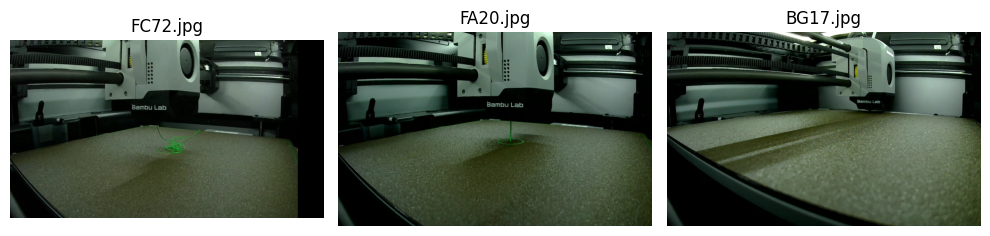

In [61]:
# Get a list of all image files in the folder

image_files = [f for f in os.listdir(train_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

# Check if there are enough images in the folder

if len(image_files) < 3:
    print(f"Err: Check folder paths")
    
else:
    # Select 3 random images
    selected_images = random.sample(image_files, 3)

    # Display the selected images with bounding boxes
    plt.figure(figsize=(10, 5))

    for i, img_file in enumerate(selected_images):
        # Read the image using OpenCV
        img_path = os.path.join(train_folder, img_file)
        img = cv2.imread(img_path)

        # Find the corresponding label file
        label_file = os.path.join(train_label_folder, os.path.splitext(img_file)[0] + '.txt')
        print(label_file)

        # If a label file exists, draw the bounding boxes
        if os.path.exists(label_file):
            img = draw_bounding_boxes(img, label_file)

        # Convert BGR to RGB for displaying with Matplotlib
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Plot the image
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(img_file)
        plt.axis('off')

    # Show the images
    plt.tight_layout()
    plt.show()

# Sanity Check - Train Model

#### Use transfer learning on a pre-trained YOLOv11 model, then evaluate

In [42]:
!pip install ultralytics

/opt/conda/lib/python3.10/pty.py:89: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


In [62]:
# Import stuff
from ultralytics import YOLO

In [71]:
# Create a new YOLO model from scratch
model = YOLO("yolo11n.yaml")

# # Load a pretrained YOLO model
# model = YOLO("yolo11n.pt")

In [72]:
from ultralytics import YOLO
import numpy as np  # Import numpy for working with infinity

# Define the YOLO model
model = YOLO("yolo11n.pt")  # Load pretrained model

# Define grid search range for epochs
epoch_values = [10, 20, 30, 50, 75, 100]  # Adjust based on your needs

# Placeholder to store results
best_epoch = None
best_map = -np.inf  # Initialize with negative infinity
results_dict = {}   # Store mAP for each epoch

# Perform grid search
for epochs in epoch_values:
    print(f"Training with {epochs} epochs...")
    # Train the model
    results = model.train(data="/kaggle/input/3dprint/3dprint.yaml", epochs=epochs)
    
    # Evaluate the model on validation data
    validation_results = model.val()
    current_map = validation_results.box.map  # Mean Average Precision (mAP)

    print(f"Epochs: {epochs}, mAP: {current_map:.4f}")
    results_dict[epochs] = current_map
    
    # Check if this is the best mAP so far
    if current_map > best_map:
        best_map = current_map
        best_epoch = epochs

# Output the best epoch and corresponding mAP
print(f"\nBest number of epochs: {best_epoch} with mAP: {best_map:.4f}")

# Display the results for all epoch values
print("\nResults for all epoch values:")
for epoch, map_score in results_dict.items():
    print(f"Epochs: {epoch}, mAP: {map_score:.4f}")


Training with 10 epochs...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/3dprint/3dprint.yaml, epochs=10, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, s

train: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/train... 86 images, 138 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 1280.68it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 652.70it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train10/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train10
Starting training for 10 epochs...
Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/10      2.68G      2.887      9.509      2.152         10        640: 100%|██████████| 14/14 [00:04<00:00,  3.27it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.21it/s]

                   all         85         41   0.000941      0.585    0.00182   0.000418



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/10      2.63G      2.506       8.68      1.683          8        640: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.75it/s]

                   all         85         41     0.0011      0.683     0.0933     0.0199



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/10      2.59G      2.433      6.873      1.871          5        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]

                   all         85         41   0.000745      0.463   0.000623    0.00019



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/10      2.59G      2.531      6.911      1.917         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.17it/s]

                   all         85         41   0.000706      0.439   0.000538   0.000209



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/10      2.59G      2.522      6.903      1.857         10        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.57it/s]

                   all         85         41    0.00129      0.805     0.0638     0.0201



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/10      2.59G      2.596      9.374      1.911          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.25it/s]

                   all         85         41      0.245      0.415      0.239       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/10      2.63G       2.42      5.177      1.805          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.38it/s]

                   all         85         41      0.729      0.197      0.374      0.136



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/10      2.59G       2.18       5.13      1.731         11        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

                   all         85         41      0.778      0.171      0.306       0.13



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/10      2.63G      2.224      4.882      1.723          3        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.29it/s]

                   all         85         41      0.686      0.293      0.406      0.167



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/10      2.59G       2.15      4.819      1.677         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.26it/s]

                   all         85         41      0.392      0.488      0.543      0.191



10 epochs completed in 0.030 hours.
Optimizer stripped from runs/detect/train10/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train10/weights/best.pt, 5.4MB

Validating runs/detect/train10/weights/best.pt...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


                   all         85         41      0.391      0.488      0.543      0.191
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 2.1ms postprocess per image
Results saved to runs/detect/train10
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 1221.91it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.74it/s]


                   all         85         41      0.444      0.512      0.552      0.195
Speed: 0.2ms preprocess, 3.8ms inference, 0.0ms loss, 4.7ms postprocess per image
Results saved to runs/detect/train102
Epochs: 10, mAP: 0.1949
Training with 20 epochs...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/3dprint/3dprint.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train103, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=

train: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/train... 86 images, 138 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 426.64it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 238.71it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train103/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train103
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      2.71G       3.08      5.985      2.428         22        640: 100%|██████████| 14/14 [00:03<00:00,  4.03it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.09it/s]

                   all         85         41   0.000549      0.341   0.000446   0.000129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20      2.66G      2.749      4.229       1.97         23        640: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]

                   all         85         41   0.000667      0.415     0.0681     0.0333



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      2.66G      2.562      3.551      1.895         21        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.85it/s]

                   all         85         41      0.679     0.0488      0.197     0.0879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20      2.65G      2.422        3.6      1.729         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.85it/s]

                   all         85         41      0.593      0.293       0.43      0.153



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20      2.65G      2.383      3.432      1.741         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         85         41      0.501      0.512      0.562      0.226



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20      2.65G       2.32      3.175      1.686          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.06it/s]

                   all         85         41      0.499      0.585      0.544      0.206



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20      2.65G      2.203      2.891      1.614         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]

                   all         85         41      0.573      0.659      0.571      0.223



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20      2.65G       2.25      3.408       1.62         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.37it/s]

                   all         85         41      0.592      0.634      0.637      0.221



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20      2.65G      2.122      2.937      1.554         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.63it/s]

                   all         85         41      0.603      0.667      0.739      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20      2.65G      2.185      2.558      1.623         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         85         41      0.714      0.634      0.726      0.255


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      2.65G      2.172      3.816      1.614          8        640: 100%|██████████| 14/14 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.86it/s]

                   all         85         41      0.669       0.64      0.728      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      2.65G       2.18      3.242      1.589          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         85         41      0.692      0.713      0.748      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      2.65G      2.065      2.919      1.591          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.88it/s]

                   all         85         41      0.644      0.707      0.711        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      2.65G      2.065       2.84      1.529          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         85         41       0.65      0.756      0.726      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      2.65G      2.134      2.859      1.635          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

                   all         85         41      0.653       0.78      0.711      0.249



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      2.65G      2.102      2.645      1.572          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.74it/s]

                   all         85         41      0.619      0.792      0.699      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      2.65G      1.934      2.695      1.503          4        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.18it/s]

                   all         85         41      0.738      0.756        0.8      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      2.65G      1.965      2.564      1.561         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         85         41      0.712      0.732      0.776      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      2.65G      1.959      2.826      1.507          5        640: 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]

                   all         85         41      0.693      0.732      0.784      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      2.65G      1.936      2.615      1.503         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.33it/s]

                   all         85         41      0.665      0.732      0.777      0.305



20 epochs completed in 0.036 hours.
Optimizer stripped from runs/detect/train103/weights/last.pt, 5.4MB
Optimizer stripped from runs/detect/train103/weights/best.pt, 5.4MB

Validating runs/detect/train103/weights/best.pt...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.14it/s]


                   all         85         41      0.658      0.756       0.75      0.311
Speed: 0.1ms preprocess, 1.8ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train103
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 1350.80it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.58it/s]


                   all         85         41      0.609      0.756      0.705      0.303
Speed: 0.1ms preprocess, 3.9ms inference, 0.0ms loss, 4.1ms postprocess per image
Results saved to runs/detect/train1032
Epochs: 20, mAP: 0.3031
Training with 30 epochs...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/3dprint/3dprint.yaml, epochs=30, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train1033, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plot

train: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/train... 86 images, 138 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 1322.06it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 611.33it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train1033/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train1033
Starting training for 30 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/30      2.68G       2.13       2.59      1.547         22        640: 100%|██████████| 14/14 [00:03<00:00,  4.10it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.74it/s]

                   all         85         41       0.64      0.683      0.669      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/30      2.66G      2.019      2.346      1.473         23        640: 100%|██████████| 14/14 [00:03<00:00,  4.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.90it/s]

                   all         85         41      0.644      0.805      0.725      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/30      2.62G      2.067      2.217      1.523         21        640: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.34it/s]

                   all         85         41      0.653      0.732      0.741      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/30      2.62G      2.022      2.287      1.521         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.62it/s]

                   all         85         41      0.645      0.585        0.7      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/30      2.62G      2.004      2.281      1.519         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.62it/s]

                   all         85         41       0.73      0.659      0.736      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/30      2.62G      1.966      2.109      1.483          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]

                   all         85         41      0.646      0.634      0.712      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/30      2.65G      1.961          2      1.489         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.22it/s]

                   all         85         41      0.623      0.726      0.713      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/30      2.62G      2.173      2.328      1.559         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.58it/s]

                   all         85         41        0.7      0.732      0.755      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/30      2.65G      1.925      1.974      1.469         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]

                   all         85         41      0.846      0.535      0.682      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/30      2.62G          2      1.839       1.53         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.52it/s]

                   all         85         41      0.753      0.732      0.733       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/30      2.65G      2.058      1.832      1.534          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.84it/s]

                   all         85         41      0.735       0.78      0.774      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/30      2.62G      2.048      1.871      1.502         20        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.18it/s]

                   all         85         41      0.727      0.732      0.732      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/30      2.65G      2.006      1.738       1.52         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.05it/s]

                   all         85         41      0.729      0.634      0.684      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/30      2.62G      2.031      1.597      1.558          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.78it/s]


                   all         85         41      0.804      0.634      0.758      0.301

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/30      2.65G      2.071      1.571      1.533         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.25it/s]

                   all         85         41      0.653      0.683      0.676      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/30      2.62G      1.917      1.562      1.447         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.23it/s]

                   all         85         41      0.633      0.683      0.636      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/30      2.65G      1.951      1.586      1.526         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.22it/s]

                   all         85         41       0.79      0.707      0.779      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/30      2.62G      1.994      1.594      1.522         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]

                   all         85         41      0.762      0.683      0.742      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/30      2.65G       1.93      1.518      1.467         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]

                   all         85         41      0.863      0.767      0.818      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/30      2.62G      1.957      1.494      1.517          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.83it/s]

                   all         85         41      0.748      0.756      0.751      0.298


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/30      2.65G      1.901      1.772      1.556          6        640: 100%|██████████| 14/14 [00:04<00:00,  3.44it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.56it/s]

                   all         85         41      0.777      0.707       0.72      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/30      2.62G      1.927      1.637      1.482          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.15it/s]

                   all         85         41      0.691      0.683      0.656      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/30      2.65G      1.902      1.612      1.498          5        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.47it/s]

                   all         85         41      0.687      0.803      0.741      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/30      2.62G      1.892      1.816      1.468          1        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]

                   all         85         41      0.754      0.749      0.729      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/30      2.65G      1.801      1.619      1.478          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.51it/s]

                   all         85         41       0.75      0.683      0.737      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/30      2.62G       1.77      1.585      1.507         10        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.16it/s]

                   all         85         41      0.818      0.732      0.773      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/30      2.65G      1.775      1.481      1.466          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.93it/s]

                   all         85         41       0.84      0.756      0.786      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/30      2.62G      1.761       1.42      1.479          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.27it/s]

                   all         85         41      0.801      0.785      0.795       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/30      2.65G      1.778       1.46      1.513          3        640: 100%|██████████| 14/14 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]

                   all         85         41       0.83       0.78      0.805      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/30      2.62G       1.82      1.382      1.482         10        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.03it/s]


                   all         85         41      0.814       0.78      0.802      0.306

30 epochs completed in 0.053 hours.
Optimizer stripped from runs/detect/train1033/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train1033/weights/best.pt, 5.5MB

Validating runs/detect/train1033/weights/best.pt...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.63it/s]


                   all         85         41      0.862      0.763      0.818      0.312
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.6ms postprocess per image
Results saved to runs/detect/train1033
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 1156.96it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.97it/s]


                   all         85         41       0.83      0.756      0.762      0.304
Speed: 0.2ms preprocess, 4.0ms inference, 0.0ms loss, 3.5ms postprocess per image
Results saved to runs/detect/train10332
Epochs: 30, mAP: 0.3040
Training with 50 epochs...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/3dprint/3dprint.yaml, epochs=50, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train10333, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, pl

train: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/train... 86 images, 138 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 543.33it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 645.83it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train10333/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train10333
Starting training for 50 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/50      2.67G      1.858      1.622      1.439         22        640: 100%|██████████| 14/14 [00:03<00:00,  4.06it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.49it/s]

                   all         85         41       0.79      0.659       0.79       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/50      2.66G      1.762      1.501       1.37         23        640: 100%|██████████| 14/14 [00:03<00:00,  4.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.64it/s]

                   all         85         41      0.755      0.683      0.778      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/50      2.65G       1.87      1.449      1.451         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.30it/s]

                   all         85         41      0.814      0.707      0.757      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/50      2.65G      1.775      1.513      1.414         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.51it/s]

                   all         85         41      0.658      0.609      0.635      0.232



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/50      2.65G      1.795      1.514      1.432         13        640: 100%|██████████| 14/14 [00:03<00:00,  4.65it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.74it/s]


                   all         85         41      0.652      0.805       0.66      0.258

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/50      2.65G      1.747       1.46      1.377          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.47it/s]

                   all         85         41      0.636      0.726      0.742      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/50      2.65G      1.762      1.473        1.4         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.78it/s]

                   all         85         41      0.695      0.634      0.753      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/50      2.61G      1.946      1.609       1.46         24        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]

                   all         85         41      0.713      0.728      0.786      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/50      2.65G      1.855      1.455      1.407         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]

                   all         85         41      0.676      0.712      0.742      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/50      2.61G       1.83      1.402      1.424         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]

                   all         85         41      0.776      0.683       0.73      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/50      2.65G      1.861      1.337      1.417          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]

                   all         85         41      0.693      0.829      0.788      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/50      2.61G      1.863      1.401      1.402         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.55it/s]

                   all         85         41      0.674      0.854       0.73      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/50      2.65G      1.818       1.26      1.438         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.48it/s]

                   all         85         41      0.727      0.732      0.736      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/50      2.61G      1.839       1.19      1.452          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.79it/s]

                   all         85         41      0.652      0.756      0.747      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/50      2.65G      1.942      1.215      1.473         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.79it/s]

                   all         85         41      0.705      0.732      0.742      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/50      2.61G      1.773        1.2      1.395         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.75it/s]


                   all         85         41      0.651      0.829      0.748      0.227

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/50      2.65G      1.805      1.221      1.454         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]

                   all         85         41       0.73       0.79      0.789      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/50      2.61G      1.923      1.315      1.446         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.52it/s]

                   all         85         41      0.728      0.756      0.753      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/50      2.65G      1.884      1.311       1.44         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.93it/s]

                   all         85         41      0.773      0.707      0.763      0.253



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/50      2.61G      1.879      1.228      1.487          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]

                   all         85         41      0.766      0.639       0.69      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/50      2.65G      1.895      1.218      1.427         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.92it/s]

                   all         85         41       0.72      0.683      0.762      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/50      2.61G      1.814       1.22      1.408         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]

                   all         85         41      0.588      0.661       0.66      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/50      2.65G       1.82      1.204      1.416         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.02it/s]

                   all         85         41      0.701      0.732       0.72      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/50      2.61G      1.839      1.242       1.46          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.88it/s]

                   all         85         41      0.641      0.707       0.72      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/50      2.65G      1.792      1.184      1.365         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.00it/s]

                   all         85         41      0.657      0.732      0.704      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/50      2.61G      1.729       1.17      1.355         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.45it/s]

                   all         85         41      0.681      0.782      0.723      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/50      2.65G      1.757      1.118      1.394          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]

                   all         85         41      0.756      0.754      0.721      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/50      2.61G      1.817      1.137      1.435         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.10it/s]

                   all         85         41      0.736      0.805      0.788      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/50      2.65G      1.816      1.193      1.475          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.03it/s]


                   all         85         41      0.807      0.683      0.744      0.231

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/50      2.61G      1.756      1.135      1.421          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.74it/s]

                   all         85         41      0.742      0.707      0.788      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/50      2.65G      1.753      1.113      1.395         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]

                   all         85         41      0.705       0.78      0.735      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/50      2.63G      1.734      1.088      1.407         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.47it/s]

                   all         85         41      0.859      0.741      0.796      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/50      2.65G      1.831      1.125      1.382         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]

                   all         85         41      0.749      0.707      0.795      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/50      2.61G       1.63      1.064      1.287         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.53it/s]

                   all         85         41      0.697      0.785      0.719      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/50      2.65G      1.754      1.043      1.344         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]

                   all         85         41       0.86       0.75      0.802      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/50      2.61G      1.639      1.029      1.339         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]

                   all         85         41      0.777       0.78      0.815      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/50      2.65G      1.638       1.05       1.34         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.02it/s]

                   all         85         41      0.817       0.76      0.797      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/50      2.61G       1.63      1.007      1.315         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.83it/s]


                   all         85         41      0.757      0.805      0.786      0.283

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/50      2.65G      1.649      1.006       1.32         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.81it/s]

                   all         85         41      0.755      0.828      0.807       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/50      2.61G       1.72     0.9945      1.334         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.49it/s]

                   all         85         41      0.865      0.779      0.774      0.274


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/50      2.65G      1.624      1.006      1.366         11        640: 100%|██████████| 14/14 [00:04<00:00,  3.45it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.04it/s]

                   all         85         41      0.803      0.756       0.72      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/50      2.61G      1.723      1.005      1.428         10        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.93it/s]

                   all         85         41      0.823      0.805      0.772      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/50      2.65G      1.591      1.018      1.349          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.37it/s]

                   all         85         41      0.757      0.829      0.793      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/50      2.61G      1.659      1.054      1.386         11        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.33it/s]

                   all         85         41      0.762      0.829      0.799      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/50      2.65G      1.603      1.033      1.347          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.86it/s]

                   all         85         41       0.76      0.854      0.798      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/50      2.61G      1.608      1.014      1.352         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.98it/s]

                   all         85         41      0.793      0.854       0.81       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/50      2.65G      1.626       0.95      1.332          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.98it/s]

                   all         85         41      0.813      0.854      0.824      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/50      2.61G      1.644     0.9912      1.397          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.07it/s]

                   all         85         41      0.833      0.854      0.829      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/50      2.65G      1.581      0.977      1.329          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.86it/s]


                   all         85         41      0.825      0.854      0.825      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/50      2.61G      1.527     0.9329      1.294         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]

                   all         85         41      0.852      0.854      0.827       0.29



50 epochs completed in 0.076 hours.
Optimizer stripped from runs/detect/train10333/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train10333/weights/best.pt, 5.5MB

Validating runs/detect/train10333/weights/best.pt...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.19it/s]


                   all         85         41      0.693      0.828       0.79      0.319
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.9ms postprocess per image
Results saved to runs/detect/train10333
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 1248.16it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.88it/s]


                   all         85         41      0.665      0.854      0.793      0.325
Speed: 0.2ms preprocess, 5.2ms inference, 0.0ms loss, 2.5ms postprocess per image
Results saved to runs/detect/train103332
Epochs: 50, mAP: 0.3248
Training with 75 epochs...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/3dprint/3dprint.yaml, epochs=75, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train103333, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, 

train: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/train... 86 images, 138 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 1248.56it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 583.95it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train103333/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train103333
Starting training for 75 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/75      2.71G      1.761       1.41      1.416         22        640: 100%|██████████| 14/14 [00:03<00:00,  4.02it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]

                   all         85         41      0.769      0.756      0.811      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/75      2.62G      1.587      1.239      1.297         23        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.46it/s]

                   all         85         41      0.716      0.732      0.744      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/75      2.66G      1.642      1.176      1.327         21        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.03it/s]

                   all         85         41      0.862      0.707      0.809      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/75      2.66G       1.57      1.192       1.32         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.46it/s]

                   all         85         41      0.732      0.805      0.795      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/75      2.66G      1.573      1.137      1.299         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.43it/s]

                   all         85         41      0.745      0.756      0.752      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/75      2.66G      1.556      1.126      1.287          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.00it/s]

                   all         85         41      0.704      0.754      0.745       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/75      2.61G      1.584      1.202      1.305         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.69it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]

                   all         85         41      0.551      0.683      0.698      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/75      2.61G      1.838      1.309      1.421         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.82it/s]

                   all         85         41      0.694      0.732      0.733       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/75      2.61G      1.734       1.17      1.372         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.45it/s]

                   all         85         41      0.687      0.707      0.698      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/75      2.61G      1.751      1.195      1.431         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.29it/s]

                   all         85         41      0.723      0.764      0.778      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/75      2.61G      1.836       1.24      1.417          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]

                   all         85         41      0.683      0.841      0.781      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/75      2.61G      1.765      1.231      1.384         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]

                   all         85         41      0.769      0.854      0.793      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/75      2.61G      1.807      1.184      1.432         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.82it/s]

                   all         85         41      0.789      0.805      0.791      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/75      2.61G      1.856       1.19      1.484          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.10it/s]


                   all         85         41      0.788      0.732      0.747      0.262

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/75      2.61G       1.94      1.232      1.464         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.27it/s]

                   all         85         41      0.639       0.78      0.722       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/75      2.61G      1.846      1.167      1.423         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.02it/s]


                   all         85         41      0.684      0.854      0.794      0.271

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/75      2.61G      1.845      1.208      1.454         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.36it/s]

                   all         85         41      0.652      0.732      0.713      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/75      2.61G      1.941      1.324      1.474         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.60it/s]

                   all         85         41      0.658      0.707       0.74       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/75      2.61G      1.904       1.25      1.452         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.69it/s]

                   all         85         41      0.747      0.732      0.766      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/75      2.61G      1.833      1.156       1.45          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]


                   all         85         41      0.746      0.715      0.742      0.291

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      21/75      2.61G      1.905      1.167      1.427         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.42it/s]

                   all         85         41      0.744      0.708      0.774      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      22/75      2.61G      1.897      1.198      1.457         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.79it/s]

                   all         85         41      0.761      0.829      0.783      0.255



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      23/75      2.61G      1.812      1.153      1.427         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.90it/s]

                   all         85         41      0.726      0.756      0.734      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      24/75      2.61G      1.862       1.17      1.455          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.40it/s]

                   all         85         41      0.618      0.634      0.674      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      25/75      2.61G       1.85      1.159      1.398         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.46it/s]

                   all         85         41       0.69      0.634      0.707      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      26/75      2.61G       1.77      1.108      1.365         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.24it/s]

                   all         85         41      0.706      0.762      0.749      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      27/75      2.61G      1.774      1.036      1.385          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.37it/s]


                   all         85         41      0.688      0.732      0.713       0.29

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      28/75      2.61G      1.803      1.092      1.409         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.43it/s]

                   all         85         41      0.691       0.78      0.796       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      29/75      2.61G      1.835      1.125      1.471          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]

                   all         85         41      0.722      0.756      0.753      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      30/75      2.61G      1.813      1.067      1.431          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]

                   all         85         41      0.815      0.805      0.799      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      31/75      2.61G      1.786      1.094      1.387         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

                   all         85         41      0.739      0.732      0.783      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      32/75      2.63G      1.718      1.034      1.388         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.76it/s]

                   all         85         41      0.798      0.773      0.816      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      33/75      2.61G      1.867      1.108      1.388         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.97it/s]

                   all         85         41      0.696      0.805      0.782      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      34/75      2.61G      1.686       1.04       1.32         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.87it/s]

                   all         85         41      0.714      0.805      0.801      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      35/75      2.61G      1.881      1.047        1.4         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]


                   all         85         41      0.768      0.732      0.775      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      36/75      2.61G      1.667      1.048      1.362         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.07it/s]

                   all         85         41       0.67      0.741      0.742      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      37/75      2.61G      1.635      1.019      1.352         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.83it/s]

                   all         85         41      0.701      0.799      0.737      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      38/75      2.61G      1.711     0.9987      1.353         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.88it/s]

                   all         85         41      0.747      0.707      0.792      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      39/75      2.61G      1.693     0.9965      1.354         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.41it/s]

                   all         85         41      0.707      0.756      0.744      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      40/75      2.61G      1.682     0.9858      1.312         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.86it/s]

                   all         85         41      0.779      0.805      0.793      0.287



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      41/75      2.61G      1.748      1.017      1.332         11        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.37it/s]


                   all         85         41      0.711      0.805      0.755      0.297

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      42/75      2.61G      1.702     0.9998      1.327         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.60it/s]

                   all         85         41      0.695      0.756      0.752      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      43/75      2.61G      1.751       1.03      1.339         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.97it/s]

                   all         85         41      0.733      0.737      0.746      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      44/75      2.61G      1.624     0.9615       1.34         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.86it/s]

                   all         85         41      0.784      0.795      0.794      0.315



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      45/75      2.61G      1.769      1.005      1.393         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.96it/s]

                   all         85         41      0.889       0.78      0.837      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      46/75      2.63G      1.634     0.9678      1.332         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.62it/s]

                   all         85         41      0.847      0.756      0.823      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      47/75      2.61G      1.674      1.022      1.354         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.53it/s]

                   all         85         41       0.66      0.829      0.768      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      48/75      2.61G       1.67     0.9822      1.346         27        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.59it/s]

                   all         85         41      0.722      0.756      0.762      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      49/75      2.61G      1.688          1      1.288         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.56it/s]

                   all         85         41      0.742       0.78      0.728      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      50/75      2.61G      1.507     0.9388      1.251          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.19it/s]

                   all         85         41      0.759      0.683      0.764      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      51/75      2.61G      1.596      1.019      1.324         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.02it/s]

                   all         85         41      0.692      0.756      0.762       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      52/75      2.61G      1.614     0.9312      1.307         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.14it/s]

                   all         85         41      0.763       0.78      0.795      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      53/75      2.61G      1.615     0.9198      1.294          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.29it/s]

                   all         85         41      0.785      0.805      0.813      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      54/75      2.61G      1.613     0.9503      1.341         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.05it/s]


                   all         85         41      0.744      0.854      0.835      0.308

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      55/75      2.61G      1.562     0.9438      1.261         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.69it/s]

                   all         85         41      0.773      0.829      0.828      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      56/75      2.61G      1.616     0.9224      1.332         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.41it/s]

                   all         85         41        0.8      0.854      0.821      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      57/75      2.61G        1.6     0.8931      1.266         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.02it/s]

                   all         85         41      0.798      0.805      0.795      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      58/75      2.61G      1.626     0.9031      1.306         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.29it/s]

                   all         85         41      0.718      0.744      0.765       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      59/75      2.61G      1.597     0.9023       1.32         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.38it/s]

                   all         85         41      0.754      0.829      0.766      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      60/75      2.61G      1.554     0.9186      1.286         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.28it/s]

                   all         85         41      0.723      0.854      0.773      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      61/75      2.61G      1.598     0.8477      1.258         30        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

                   all         85         41      0.716      0.829      0.771      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      62/75      2.61G      1.571     0.8959      1.294         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.19it/s]

                   all         85         41      0.727      0.829       0.81      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      63/75      2.61G      1.488     0.8998      1.234         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.53it/s]

                   all         85         41      0.725      0.829      0.791      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      64/75      2.61G      1.593     0.9048      1.263         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]

                   all         85         41      0.698      0.756      0.746      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      65/75      2.61G       1.52     0.8917       1.27         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.58it/s]

                   all         85         41      0.716      0.732      0.738      0.313


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      66/75      2.61G      1.434     0.8687      1.256         10        640: 100%|██████████| 14/14 [00:04<00:00,  3.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.46it/s]

                   all         85         41      0.744      0.782      0.745      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      67/75      2.61G      1.467     0.8526      1.281          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.72it/s]

                   all         85         41      0.783      0.829       0.75      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      68/75      2.61G      1.469     0.8448      1.266          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.83it/s]

                   all         85         41       0.74      0.805      0.725      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      69/75      2.61G      1.477     0.8507      1.243          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.34it/s]

                   all         85         41      0.767      0.724      0.749      0.294



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      70/75      2.61G      1.409     0.8348      1.239         10        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.55it/s]

                   all         85         41      0.747      0.805      0.743      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      71/75      2.61G      1.475     0.8423       1.27         10        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.43it/s]

                   all         85         41      0.744      0.756      0.741       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      72/75      2.61G      1.465     0.8144       1.29          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.69it/s]

                   all         85         41      0.724      0.769      0.737      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      73/75      2.61G      1.461     0.8414      1.302          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]

                   all         85         41      0.769      0.829      0.753       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      74/75      2.61G      1.485     0.8219      1.283          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.27it/s]

                   all         85         41      0.754      0.823      0.756      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      75/75      2.61G      1.454     0.8231      1.301         11        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.91it/s]

                   all         85         41      0.731      0.829      0.749      0.288



75 epochs completed in 0.105 hours.
Optimizer stripped from runs/detect/train103333/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train103333/weights/best.pt, 5.5MB

Validating runs/detect/train103333/weights/best.pt...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  4.48it/s]


                   all         85         41      0.769      0.756      0.812       0.33
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 2.4ms postprocess per image
Results saved to runs/detect/train103333
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 1320.85it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  4.62it/s]


                   all         85         41      0.769      0.756      0.812      0.331
Speed: 0.2ms preprocess, 3.0ms inference, 0.0ms loss, 3.6ms postprocess per image
Results saved to runs/detect/train1033332
Epochs: 75, mAP: 0.3310
Training with 100 epochs...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/3dprint/3dprint.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train1033333, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=Fal

train: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/train... 86 images, 138 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 1062.70it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 749.62it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train1033333/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train1033333
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.72G      1.657      1.329      1.368         22        640: 100%|██████████| 14/14 [00:03<00:00,  4.11it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.23it/s]

                   all         85         41      0.716      0.707      0.754      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.67G      1.579      1.216      1.294         23        640: 100%|██████████| 14/14 [00:03<00:00,  4.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.53it/s]

                   all         85         41      0.688      0.752      0.754      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.66G      1.662       1.17      1.334         21        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.60it/s]

                   all         85         41      0.813      0.707      0.788      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.66G      1.586      1.181      1.336         14        640: 100%|██████████| 14/14 [00:03<00:00,  4.43it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.51it/s]

                   all         85         41      0.684      0.634      0.711       0.25



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.66G      1.597      1.151      1.325         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.35it/s]

                   all         85         41      0.747      0.805      0.753      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.66G      1.589      1.149      1.296          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.28it/s]

                   all         85         41      0.636      0.756      0.734      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.66G       1.64      1.213      1.316         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.25it/s]


                   all         85         41      0.587      0.683      0.671      0.251

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.66G      1.846      1.332      1.419         24        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.71it/s]

                   all         85         41      0.698      0.756      0.747      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.66G       1.83      1.194      1.409         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.44it/s]

                   all         85         41      0.653      0.878        0.8      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.66G      1.768      1.175      1.419         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.68it/s]

                   all         85         41      0.619      0.794      0.698      0.238



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.66G      1.838      1.224      1.432          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.13it/s]

                   all         85         41      0.743      0.776      0.704      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.66G      1.792      1.219      1.405         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.72it/s]

                   all         85         41      0.718      0.732       0.68      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.66G      1.808      1.191      1.444         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.42it/s]

                   all         85         41      0.707      0.824      0.709      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.67G      1.819      1.129      1.469          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.90it/s]

                   all         85         41      0.723      0.707      0.747      0.256



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.66G      1.938      1.177      1.482         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.34it/s]

                   all         85         41      0.731      0.805      0.773      0.237



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.66G      1.781      1.125      1.394         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.68it/s]


                   all         85         41      0.686      0.805      0.712      0.267

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.66G      1.816      1.135      1.446         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.94it/s]

                   all         85         41       0.69      0.829       0.77      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.66G      1.935      1.234      1.467         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.30it/s]

                   all         85         41      0.721      0.805      0.756      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.67G      1.835      1.224      1.434         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.30it/s]

                   all         85         41      0.853      0.854      0.798      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.66G      1.894      1.155      1.473          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.36it/s]

                   all         85         41      0.884      0.805      0.811      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.66G      1.865      1.172      1.423         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.21it/s]

                   all         85         41      0.767      0.756      0.757      0.282



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.66G      1.805       1.16      1.416         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.37it/s]

                   all         85         41      0.789      0.732      0.765      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.66G      1.835      1.108      1.426         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.24it/s]

                   all         85         41      0.732      0.801      0.768      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.66G      1.858      1.104      1.442          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.48it/s]

                   all         85         41      0.639      0.732      0.757      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.66G      1.789      1.075      1.368         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.67it/s]

                   all         85         41      0.625      0.692      0.708      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.66G      1.726      1.114      1.348         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.84it/s]

                   all         85         41      0.712      0.707      0.708      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.66G      1.746      1.067       1.37          6        640: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.57it/s]

                   all         85         41      0.774      0.732       0.75      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.66G      1.767       1.08      1.393         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 11.08it/s]

                   all         85         41      0.772      0.827      0.794      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.66G      1.869      1.157      1.488          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.79it/s]

                   all         85         41      0.806       0.78      0.741      0.314



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.66G      1.843      1.069      1.448          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.46it/s]

                   all         85         41      0.706      0.756      0.687      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.66G       1.76      1.059      1.395         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.31it/s]

                   all         85         41      0.626      0.736      0.659      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.68G      1.763       1.04      1.423         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.26it/s]

                   all         85         41       0.74       0.78      0.757      0.257



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.66G      1.811      1.109      1.371         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.34it/s]

                   all         85         41      0.701       0.78      0.783      0.273



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.66G      1.612      1.014      1.277         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.53it/s]

                   all         85         41      0.621      0.758      0.659      0.227



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.66G       1.86       1.05      1.379         17        640: 100%|██████████| 14/14 [00:03<00:00,  4.59it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.63it/s]

                   all         85         41      0.812      0.756      0.809      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.66G      1.722      1.045      1.378         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.76it/s]

                   all         85         41      0.757      0.756      0.791      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.66G      1.651     0.9999      1.351         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.53it/s]

                   all         85         41      0.789      0.729      0.682      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.66G      1.701     0.9955      1.338         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.09it/s]

                   all         85         41      0.752      0.683      0.679      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.66G      1.661      1.003        1.3         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.51it/s]

                   all         85         41       0.66       0.78       0.65      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.66G      1.685      1.009      1.299         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.61it/s]

                   all         85         41      0.724      0.756       0.73      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.66G       1.79      1.068      1.355         11        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]

                   all         85         41      0.742      0.683      0.732      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.66G       1.72     0.9985      1.338         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.65it/s]

                   all         85         41      0.752       0.78      0.733      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.66G      1.804      1.019      1.364         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.37it/s]


                   all         85         41      0.795      0.755      0.809       0.32

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.66G      1.668     0.9743      1.357         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.76it/s]

                   all         85         41      0.819      0.707      0.764      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.66G      1.741     0.9858      1.359         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.33it/s]

                   all         85         41      0.821      0.669      0.768      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.68G      1.628     0.9409      1.304         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.87it/s]

                   all         85         41      0.821      0.784      0.805       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.66G      1.727      1.041      1.382         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]

                   all         85         41       0.79      0.829      0.777      0.266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.66G      1.714     0.9768      1.404         27        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.41it/s]

                   all         85         41      0.801      0.805      0.816       0.28



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.66G      1.688      1.005      1.322         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.21it/s]

                   all         85         41      0.771      0.739      0.797      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.66G      1.547     0.9646      1.292          9        640: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.33it/s]


                   all         85         41       0.79      0.732      0.843      0.321

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.66G      1.647      1.009      1.344         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.50it/s]

                   all         85         41       0.79      0.756      0.825      0.268



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.66G      1.584     0.9621      1.299         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.03it/s]

                   all         85         41      0.819      0.772      0.787      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.66G      1.615     0.9266      1.299          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.03it/s]

                   all         85         41      0.789      0.829      0.835      0.286



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.66G      1.617     0.9375      1.357         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.62it/s]

                   all         85         41      0.818      0.766      0.803      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.66G      1.541     0.9591      1.256         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.62it/s]

                   all         85         41      0.767      0.722       0.79      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.66G      1.622     0.9395      1.339         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.64it/s]

                   all         85         41      0.739      0.756      0.762      0.293



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.66G       1.63     0.8977      1.287         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.73it/s]

                   all         85         41      0.764      0.789      0.767      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.66G       1.59     0.9046       1.31         22        640: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.73it/s]


                   all         85         41      0.812      0.739      0.754      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.66G      1.618     0.8905      1.357         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.32it/s]

                   all         85         41      0.788      0.707      0.752      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.66G      1.581     0.9437      1.303         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.49it/s]


                   all         85         41        0.8      0.779      0.779      0.287

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.66G      1.599     0.8359      1.276         30        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.88it/s]

                   all         85         41      0.852       0.78      0.816      0.302



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.66G      1.592       0.91      1.315         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.59it/s]

                   all         85         41      0.748      0.805      0.782      0.284



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.66G      1.521     0.9034      1.243         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.47it/s]

                   all         85         41       0.72      0.805       0.79      0.313



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.66G      1.655     0.9322      1.272         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.65it/s]

                   all         85         41      0.825      0.756      0.819      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.66G      1.537     0.8974      1.275         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.00it/s]

                   all         85         41      0.709       0.83      0.778      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.66G      1.604     0.9627      1.309         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.86it/s]

                   all         85         41      0.735      0.814      0.737      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.66G      1.523     0.8805      1.279         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.98it/s]

                   all         85         41      0.783       0.78      0.722      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.66G      1.515     0.8589      1.251         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]

                   all         85         41      0.803      0.805      0.796       0.31



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.66G      1.529     0.9026      1.299         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.50it/s]

                   all         85         41      0.851      0.837      0.801      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.66G      1.429     0.8372      1.222          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.28it/s]

                   all         85         41      0.827      0.817      0.792      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.66G      1.545     0.8693      1.267         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.52it/s]

                   all         85         41      0.792      0.854      0.799      0.308



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.66G      1.495     0.8277      1.252         28        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.98it/s]

                   all         85         41      0.783      0.791      0.741      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.66G      1.495     0.8539      1.267         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.09it/s]

                   all         85         41      0.801      0.805      0.754      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.66G      1.549     0.8584      1.253         21        640: 100%|██████████| 14/14 [00:03<00:00,  4.66it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.29it/s]

                   all         85         41      0.789       0.78      0.804      0.296



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.66G      1.403     0.8325      1.211         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.18it/s]

                   all         85         41      0.849       0.82      0.798      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.66G      1.501     0.8328      1.248         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.80it/s]

                   all         85         41      0.796       0.78      0.786      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.66G      1.461     0.8388      1.188          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.92it/s]

                   all         85         41      0.794      0.845      0.862      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.66G      1.424     0.8359      1.212         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.78it/s]

                   all         85         41      0.814      0.852      0.862      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.66G      1.466     0.7724      1.229         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.95it/s]

                   all         85         41      0.842      0.829       0.81      0.319



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.66G       1.42     0.8115      1.209         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.81it/s]

                   all         85         41      0.779       0.78      0.738      0.301



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.66G       1.42       0.81      1.213         23        640: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.52it/s]

                   all         85         41      0.802      0.789       0.79      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.66G      1.387     0.7781      1.191         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.44it/s]

                   all         85         41      0.838      0.758       0.79      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.66G      1.449     0.7898      1.228         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.41it/s]

                   all         85         41      0.899      0.805      0.862      0.334



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.66G      1.417     0.7876      1.177         11        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.96it/s]

                   all         85         41      0.889      0.805      0.875      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.66G      1.546     0.8289      1.288          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.74it/s]

                   all         85         41       0.88       0.78      0.835      0.316



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.66G      1.513     0.8203      1.266         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]


                   all         85         41      0.943      0.804      0.873      0.304

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.66G       1.37     0.7697      1.178         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.66it/s]

                   all         85         41      0.872      0.805      0.829      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.66G       1.35     0.7828      1.187         23        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.37it/s]

                   all         85         41      0.843      0.829      0.818      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.66G      1.387     0.8133      1.186         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.80it/s]

                   all         85         41      0.869      0.807      0.862      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.66G      1.301     0.8044      1.154         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.61it/s]

                   all         85         41      0.889      0.805      0.858      0.307


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.66G      1.447      0.772      1.286          8        640: 100%|██████████| 14/14 [00:04<00:00,  3.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.99it/s]

                   all         85         41       0.87      0.815      0.846      0.303



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.66G      1.407     0.7791      1.248          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.82it/s]

                   all         85         41      0.837      0.753      0.777      0.298



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.66G      1.354     0.7718      1.195          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.86it/s]


                   all         85         41      0.833      0.756      0.774      0.295

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.66G      1.302     0.7722      1.209          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.94it/s]

                   all         85         41      0.823      0.792      0.784      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.66G      1.387      0.816      1.191         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.21it/s]


                   all         85         41      0.854      0.756      0.795      0.289

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.66G       1.26     0.7616      1.192         10        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.53it/s]


                   all         85         41      0.877      0.756        0.8      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.66G      1.357     0.7856        1.2          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.23it/s]

                   all         85         41      0.881      0.756      0.803      0.289



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.66G      1.321     0.7761       1.19          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.96it/s]

                   all         85         41      0.831      0.732       0.76      0.292



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.66G      1.337     0.7467      1.204          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.28it/s]

                   all         85         41      0.874       0.78      0.815      0.299



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.66G      1.276     0.7352      1.183         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.35it/s]

                   all         85         41      0.828      0.823       0.82      0.298



100 epochs completed in 0.133 hours.
Optimizer stripped from runs/detect/train1033333/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train1033333/weights/best.pt, 5.5MB

Validating runs/detect/train1033333/weights/best.pt...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.30it/s]


                   all         85         41      0.889      0.805      0.875      0.338
Speed: 0.1ms preprocess, 1.7ms inference, 0.0ms loss, 1.5ms postprocess per image
Results saved to runs/detect/train1033333
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 1117.70it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.20it/s]


                   all         85         41      0.861      0.854      0.877      0.339
Speed: 0.1ms preprocess, 3.0ms inference, 0.0ms loss, 3.2ms postprocess per image
Results saved to runs/detect/train10333332
Epochs: 100, mAP: 0.3395

Best number of epochs: 100 with mAP: 0.3395

Results for all epoch values:
Epochs: 10, mAP: 0.1949
Epochs: 20, mAP: 0.3031
Epochs: 30, mAP: 0.3040
Epochs: 50, mAP: 0.3248
Epochs: 75, mAP: 0.3310
Epochs: 100, mAP: 0.3395


In [66]:
# Train the model using the 'coco8.yaml' dataset for 3 epochs
results = model.train(data="/kaggle/input/3dprint/3dprint.yaml", epochs=100)

Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
engine/trainer: task=detect, mode=train, model=yolo11n.pt, data=/kaggle/input/3dprint/3dprint.yaml, epochs=100, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train93, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf

train: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/train... 86 images, 138 backgrounds, 0 corrupt: 100%|██████████| 224/224 [00:00<00:00, 1235.19it/s]

train: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 744.24it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.


Plotting labels to runs/detect/train93/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 81 weight(decay=0.0), 88 weight(decay=0.0005), 87 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 640 train, 640 val
Using 4 dataloader workers
Logging results to runs/detect/train93
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      2.68G      3.121      4.749      2.388         22        640: 100%|██████████| 14/14 [00:03<00:00,  4.22it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.54it/s]

                   all         85         41          1      0.112      0.216     0.0698



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      2.65G      2.471      3.246      1.852         23        640: 100%|██████████| 14/14 [00:03<00:00,  4.64it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.27it/s]

                   all         85         41       0.81      0.122      0.192     0.0881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      2.61G       2.31      2.714      1.761         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.55it/s]

                   all         85         41      0.855      0.145      0.272      0.113



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      2.61G      2.296      2.817      1.686         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.10it/s]

                   all         85         41      0.581      0.203      0.421      0.142



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      2.61G      2.197      2.637      1.669         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.59it/s]

                   all         85         41      0.455      0.512      0.519      0.193



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      2.61G      2.161      2.392      1.644          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]

                   all         85         41      0.668      0.512      0.666      0.234



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      2.65G      2.091      2.223      1.601         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.20it/s]

                   all         85         41      0.593       0.61      0.567       0.22



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      2.61G      2.224      2.411      1.652         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.99it/s]

                   all         85         41      0.594      0.714      0.718      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      2.65G      2.022      2.203      1.539         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.64it/s]

                   all         85         41      0.629      0.683      0.701      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      2.61G      2.104      1.952      1.614         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.73it/s]


                   all         85         41      0.717       0.61      0.748      0.284

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      2.65G      2.174      1.922      1.563          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.91it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.28it/s]

                   all         85         41      0.666       0.68      0.712      0.297



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      2.61G      2.115      1.968       1.55         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.69it/s]

                   all         85         41      0.565      0.634      0.545      0.191



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      2.65G       2.06      1.764      1.573         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.61it/s]

                   all         85         41      0.715      0.734      0.747      0.271



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      2.61G      2.034       1.64      1.618          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.07it/s]


                   all         85         41      0.713      0.786      0.777      0.252

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      2.65G      2.145      1.637        1.6         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.96it/s]

                   all         85         41      0.619      0.756      0.682      0.244



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      2.61G      2.107       1.63       1.56         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.14it/s]

                   all         85         41      0.593      0.756        0.7      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      2.65G      2.024      1.608      1.586         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.43it/s]

                   all         85         41       0.66      0.616      0.703       0.24



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      2.61G      2.104      1.738      1.609         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.24it/s]

                   all         85         41      0.707      0.683       0.71      0.277



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      2.65G      2.032      1.542      1.597         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.56it/s]

                   all         85         41      0.755      0.805      0.753      0.263



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      2.61G      2.064      1.493      1.602          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.11it/s]

                   all         85         41       0.75      0.804      0.815      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      2.65G      1.977      1.421      1.506         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.91it/s]

                   all         85         41      0.731      0.731      0.795       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      2.61G      1.974       1.43        1.5         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.02it/s]

                   all         85         41      0.846      0.561      0.764      0.288



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      2.65G      1.962        1.4      1.518         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.69it/s]

                   all         85         41      0.639       0.78       0.69      0.247



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      2.61G      1.996       1.36      1.546          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.24it/s]

                   all         85         41      0.575      0.634      0.725      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      2.65G      1.952      1.359       1.49         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.46it/s]

                   all         85         41      0.709      0.683      0.762      0.272



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      2.61G      1.925      1.349      1.492         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.83it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.49it/s]

                   all         85         41      0.701      0.685      0.765      0.285



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      2.65G      1.903      1.292      1.493          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.99it/s]

                   all         85         41      0.723       0.78      0.816      0.317



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      2.61G      1.954      1.259      1.544         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.73it/s]

                   all         85         41      0.827        0.7      0.808      0.306



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      2.65G      1.995      1.346      1.591          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.16it/s]

                   all         85         41      0.827      0.701      0.748      0.262



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      2.61G      1.897       1.27      1.526          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.05it/s]


                   all         85         41      0.624      0.707      0.672      0.225

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      2.65G      1.873      1.227      1.508         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.73it/s]

                   all         85         41      0.697      0.805      0.765      0.251



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      2.63G      1.827      1.188      1.481         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.44it/s]

                   all         85         41      0.784      0.805      0.815      0.278



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      2.65G      1.971      1.243      1.492         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.33it/s]


                   all         85         41      0.727      0.829      0.813      0.277

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      2.61G      1.777      1.181      1.386         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]

                   all         85         41      0.776      0.805      0.815      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      2.65G      1.899      1.197       1.45         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.70it/s]

                   all         85         41      0.804      0.829      0.836      0.267



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      2.61G      1.815       1.16      1.467         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.66it/s]

                   all         85         41      0.794       0.78      0.787      0.259



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      2.65G      1.802      1.158      1.471         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.64it/s]

                   all         85         41      0.739      0.805      0.792      0.279



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      2.61G      1.761      1.152      1.428         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.01it/s]

                   all         85         41      0.744      0.708      0.785      0.283



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      2.65G       1.78      1.078      1.409         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.59it/s]

                   all         85         41      0.706      0.829      0.797      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      2.61G       1.79      1.109      1.405         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.47it/s]

                   all         85         41      0.751      0.854      0.865      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      2.65G      1.893      1.179      1.423         11        640: 100%|██████████| 14/14 [00:02<00:00,  4.94it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.78it/s]

                   all         85         41      0.847      0.813      0.857      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      2.61G      1.751      1.087      1.403         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.96it/s]

                   all         85         41      0.899      0.871      0.884       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      2.65G      1.856      1.146      1.422         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.46it/s]

                   all         85         41      0.786      0.707      0.803      0.311



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      2.61G      1.762      1.124      1.466         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.43it/s]

                   all         85         41      0.742      0.773       0.78      0.276



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      2.65G      1.867      1.094      1.479         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.90it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.14it/s]

                   all         85         41      0.694      0.829      0.769      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      2.62G      1.756      1.067      1.427         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00, 10.19it/s]

                   all         85         41      0.703      0.829      0.782       0.27



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      2.65G      1.801      1.156      1.461         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.82it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.95it/s]

                   all         85         41       0.76      0.772      0.793      0.291



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      2.61G      1.786      1.089      1.464         27        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.18it/s]

                   all         85         41       0.79      0.824      0.797      0.274



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      2.65G      1.775      1.066        1.4         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.64it/s]

                   all         85         41      0.795      0.829      0.817      0.304



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      2.61G      1.682      1.071      1.422          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.83it/s]

                   all         85         41       0.78      0.829      0.824      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      2.65G      1.694      1.099      1.367         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.92it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.52it/s]

                   all         85         41      0.753      0.817      0.811      0.305



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      2.61G      1.704      1.046      1.398         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.81it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.30it/s]

                   all         85         41       0.78      0.732      0.761      0.265



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      2.65G      1.704       1.06      1.365          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.48it/s]

                   all         85         41      0.746      0.829      0.794      0.269



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      2.61G      1.747      1.011      1.432         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.67it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.18it/s]


                   all         85         41      0.812      0.842      0.801      0.273

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      2.65G      1.691      1.003      1.358         19        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.97it/s]

                   all         85         41      0.821      0.756      0.772       0.29



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      2.61G      1.667     0.9932      1.379         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.44it/s]

                   all         85         41      0.814      0.749      0.808      0.295



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      2.65G      1.702     0.9911      1.326         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.38it/s]

                   all         85         41       0.77      0.756      0.797        0.3



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      2.61G      1.701     0.9682      1.361         22        640: 100%|██████████| 14/14 [00:02<00:00,  4.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.55it/s]

                   all         85         41      0.781      0.868      0.846      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      2.65G      1.721     0.9713      1.414         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.34it/s]

                   all         85         41       0.81      0.832      0.825      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      2.61G      1.653     0.9836      1.342         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.45it/s]

                   all         85         41      0.867      0.805      0.824      0.318



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      2.65G      1.666     0.9344      1.332         30        640: 100%|██████████| 14/14 [00:03<00:00,  3.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.96it/s]

                   all         85         41      0.784      0.829      0.813      0.307



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      2.61G        1.7     0.9835       1.38         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.77it/s]

                   all         85         41      0.822       0.79       0.83       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      2.65G      1.611      0.978      1.312         24        640: 100%|██████████| 14/14 [00:02<00:00,  4.89it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.15it/s]

                   all         85         41      0.789      0.823      0.806      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      2.61G        1.7      1.042      1.362         16        640: 100%|██████████| 14/14 [00:03<00:00,  4.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.14it/s]

                   all         85         41      0.728      0.805       0.79      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      2.65G      1.644      1.001      1.367         20        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.37it/s]

                   all         85         41      0.764      0.805      0.812      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      2.61G      1.607      1.061      1.352         17        640: 100%|██████████| 14/14 [00:02<00:00,  4.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.04it/s]

                   all         85         41      0.747      0.829      0.799      0.331



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      2.65G      1.617     0.9792      1.385         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.39it/s]

                   all         85         41      0.836       0.87       0.86      0.322



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      2.61G      1.624     0.9572       1.32         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.04it/s]

                   all         85         41      0.853      0.829      0.858      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      2.65G      1.587     0.9944      1.343         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.87it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.95it/s]

                   all         85         41      0.814      0.756      0.797      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      2.61G      1.513     0.9071       1.29          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.42it/s]

                   all         85         41      0.806      0.878      0.848      0.309



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      2.65G      1.663     0.9445      1.339         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.86it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.78it/s]


                   all         85         41      0.814      0.878      0.857      0.335

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      2.61G      1.569     0.9565       1.32         28        640: 100%|██████████| 14/14 [00:03<00:00,  4.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.87it/s]


                   all         85         41      0.794      0.849      0.839      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      2.65G      1.652     0.9562      1.373         14        640: 100%|██████████| 14/14 [00:03<00:00,  3.96it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.05it/s]

                   all         85         41       0.76      0.902      0.838      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      2.61G      1.646     0.9546      1.335         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.94it/s]

                   all         85         41      0.856      0.873      0.876      0.343



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      2.65G      1.555     0.8886      1.314         12        640: 100%|██████████| 14/14 [00:02<00:00,  4.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.74it/s]

                   all         85         41      0.844      0.829      0.844       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      2.61G      1.555     0.9047      1.315         16        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.84it/s]

                   all         85         41      0.772      0.854      0.804      0.321



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      2.65G      1.575     0.9307      1.266          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.85it/s]

                   all         85         41      0.884      0.805      0.845       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      2.61G      1.502     0.8937      1.284         21        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.47it/s]

                   all         85         41      0.867      0.805       0.86      0.326



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      2.65G      1.527     0.8715      1.287         17        640: 100%|██████████| 14/14 [00:03<00:00,  4.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.99it/s]

                   all         85         41      0.862      0.805      0.856       0.34



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      2.61G      1.469     0.8982      1.263         13        640: 100%|██████████| 14/14 [00:03<00:00,  4.62it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.23it/s]

                   all         85         41      0.898      0.805      0.839       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      2.65G      1.444     0.8695      1.261         23        640: 100%|██████████| 14/14 [00:02<00:00,  4.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.80it/s]

                   all         85         41      0.896      0.843      0.842      0.329



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      2.61G      1.475     0.8787      1.261         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.41it/s]

                   all         85         41      0.885      0.829       0.84      0.324



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      2.65G      1.487     0.8606      1.273         14        640: 100%|██████████| 14/14 [00:02<00:00,  4.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.30it/s]

                   all         85         41      0.897      0.845      0.829      0.332



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      2.61G      1.519     0.9007      1.256         11        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.81it/s]

                   all         85         41      0.885      0.854      0.825      0.338



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      2.65G      1.632      0.929      1.364          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.36it/s]

                   all         85         41      0.914      0.854      0.836      0.339



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      2.61G      1.634     0.9186      1.352         18        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.29it/s]

                   all         85         41      0.897      0.853      0.833      0.328



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      2.65G      1.466     0.8466      1.244         12        640: 100%|██████████| 14/14 [00:03<00:00,  4.33it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.84it/s]

                   all         85         41      0.894      0.827      0.833      0.336



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      2.61G       1.43     0.8445      1.259         23        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.72it/s]

                   all         85         41      0.865      0.829      0.832       0.32



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      2.65G      1.489     0.8847      1.262         20        640: 100%|██████████| 14/14 [00:03<00:00,  4.63it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.77it/s]

                   all         85         41      0.894      0.826      0.835      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      2.61G      1.382     0.9406      1.242         18        640: 100%|██████████| 14/14 [00:03<00:00,  4.61it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.47it/s]

                   all         85         41      0.878      0.829      0.836      0.325


Closing dataloader mosaic
albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01, num_output_channels=3, method='weighted_average'), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))


/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      2.65G       1.46     0.8526       1.33          8        640: 100%|██████████| 14/14 [00:04<00:00,  3.17it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  7.56it/s]

                   all         85         41      0.883      0.829      0.829      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      2.61G      1.433     0.8476       1.29          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.70it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.86it/s]

                   all         85         41      0.842      0.805      0.807      0.344



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      2.65G      1.416     0.8371      1.275          9        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.82it/s]

                   all         85         41      0.838      0.805      0.802      0.335



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      2.61G      1.346     0.8332      1.264          9        640: 100%|██████████| 14/14 [00:03<00:00,  4.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.43it/s]

                   all         85         41      0.843      0.805      0.804      0.341



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      2.65G      1.476     0.8703      1.296         13        640: 100%|██████████| 14/14 [00:02<00:00,  4.79it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.62it/s]

                   all         85         41       0.92      0.847      0.834      0.337



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      2.61G      1.343     0.8033      1.291         10        640: 100%|██████████| 14/14 [00:02<00:00,  4.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.82it/s]

                   all         85         41      0.904      0.829      0.829      0.325



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      2.65G      1.415     0.8614      1.252          7        640: 100%|██████████| 14/14 [00:02<00:00,  4.80it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.04it/s]

                   all         85         41      0.921      0.849      0.831      0.312



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      2.61G      1.378     0.8331       1.28          6        640: 100%|██████████| 14/14 [00:02<00:00,  4.68it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.18it/s]


                   all         85         41      0.921      0.849      0.833      0.319

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      2.65G        1.4     0.8359      1.265          8        640: 100%|██████████| 14/14 [00:02<00:00,  4.76it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  8.50it/s]

                   all         85         41       0.88      0.805      0.794       0.33



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      2.61G       1.32     0.8282      1.269         15        640: 100%|██████████| 14/14 [00:02<00:00,  4.71it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  9.30it/s]

                   all         85         41       0.84      0.768      0.795      0.332



100 epochs completed in 0.133 hours.
Optimizer stripped from runs/detect/train93/weights/last.pt, 5.5MB
Optimizer stripped from runs/detect/train93/weights/best.pt, 5.5MB

Validating runs/detect/train93/weights/best.pt...
Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 3/3 [00:00<00:00,  5.12it/s]


                   all         85         41      0.856      0.871      0.876      0.342
Speed: 0.1ms preprocess, 1.5ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/train93


In [67]:
# Evaluate the model's performance on the validation set
results = model.val()

Ultralytics 8.3.37 🚀 Python-3.10.14 torch-2.4.0 CUDA:0 (Tesla P100-PCIE-16GB, 16269MiB)
YOLO11n summary (fused): 238 layers, 2,582,347 parameters, 0 gradients, 6.3 GFLOPs


val: Scanning /kaggle/input/dataset-3dprint/3dprint/labels/val... 30 images, 55 backgrounds, 0 corrupt: 100%|██████████| 85/85 [00:00<00:00, 1207.71it/s]

val: WARNING ⚠️ Cache directory /kaggle/input/dataset-3dprint/3dprint/labels is not writeable, cache not saved.



/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 6/6 [00:01<00:00,  5.21it/s]


                   all         85         41      0.876      0.862      0.878      0.338
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 2.2ms postprocess per image
Results saved to runs/detect/train932


# View Results

In [51]:
# Load the generated images
image1 = r"./runs/detect/train823/val_batch0_labels.jpg"
image2 = r"./runs/detect/train823/val_batch0_pred.jpg"
image3 = r"./runs/detect/train823/val_batch1_labels.jpg"
image4 = r"./runs/detect/train823/val_batch1_pred.jpg"

------------------ [PREDICTION] ./runs/detect/train823/val_batch0_labels.jpg ------------------


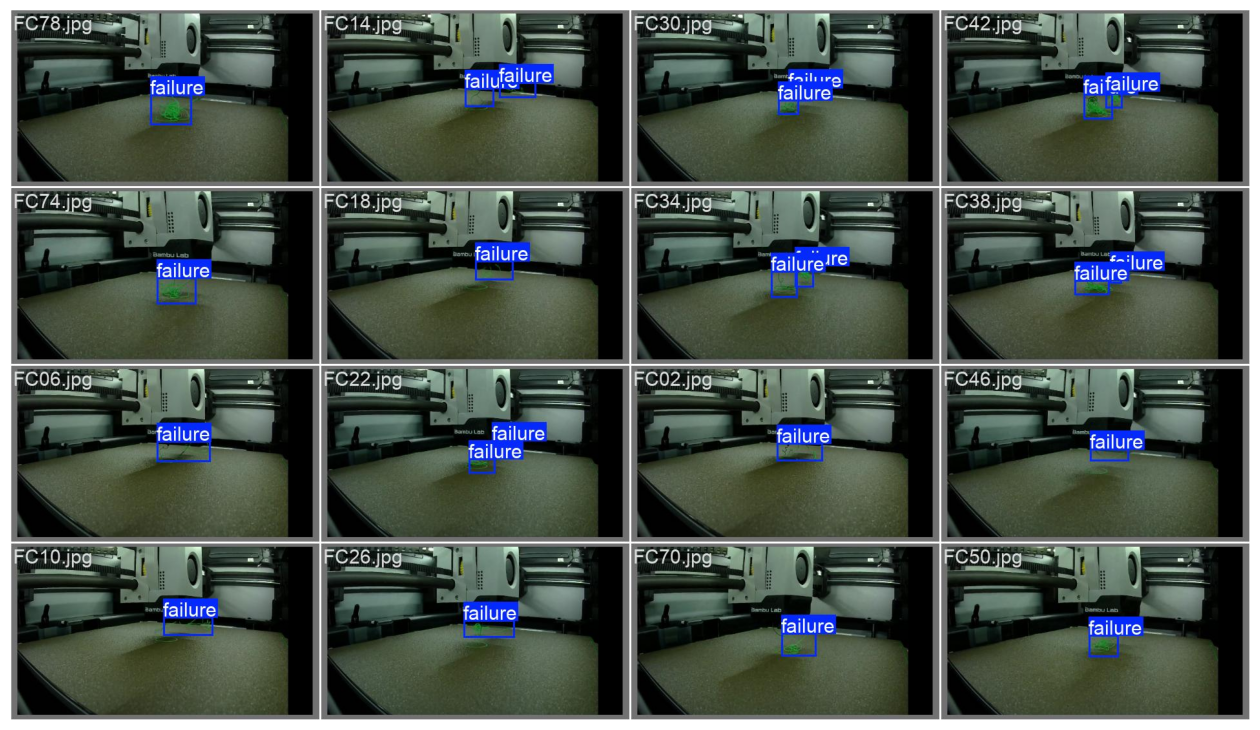



------------------ [LABEL] ./runs/detect/train823/val_batch0_pred.jpg ------------------


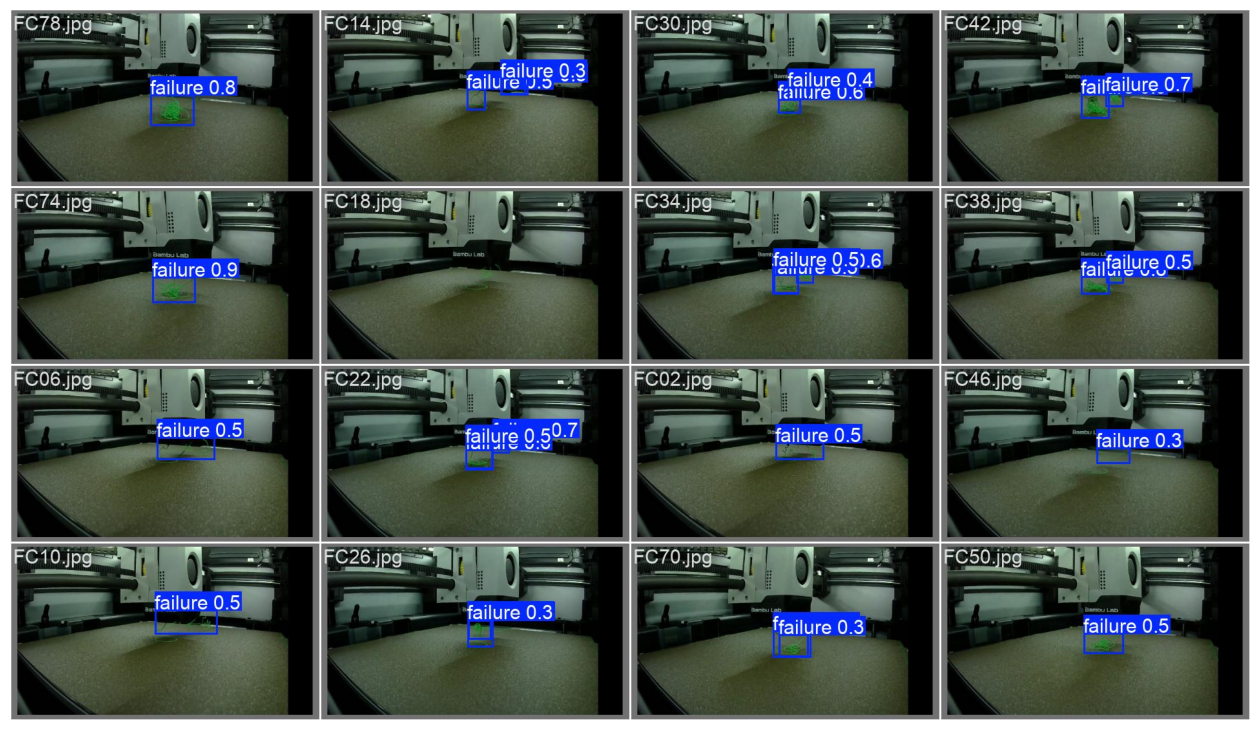



------------------ [PREDICTION] ./runs/detect/train823/val_batch1_labels.jpg ------------------


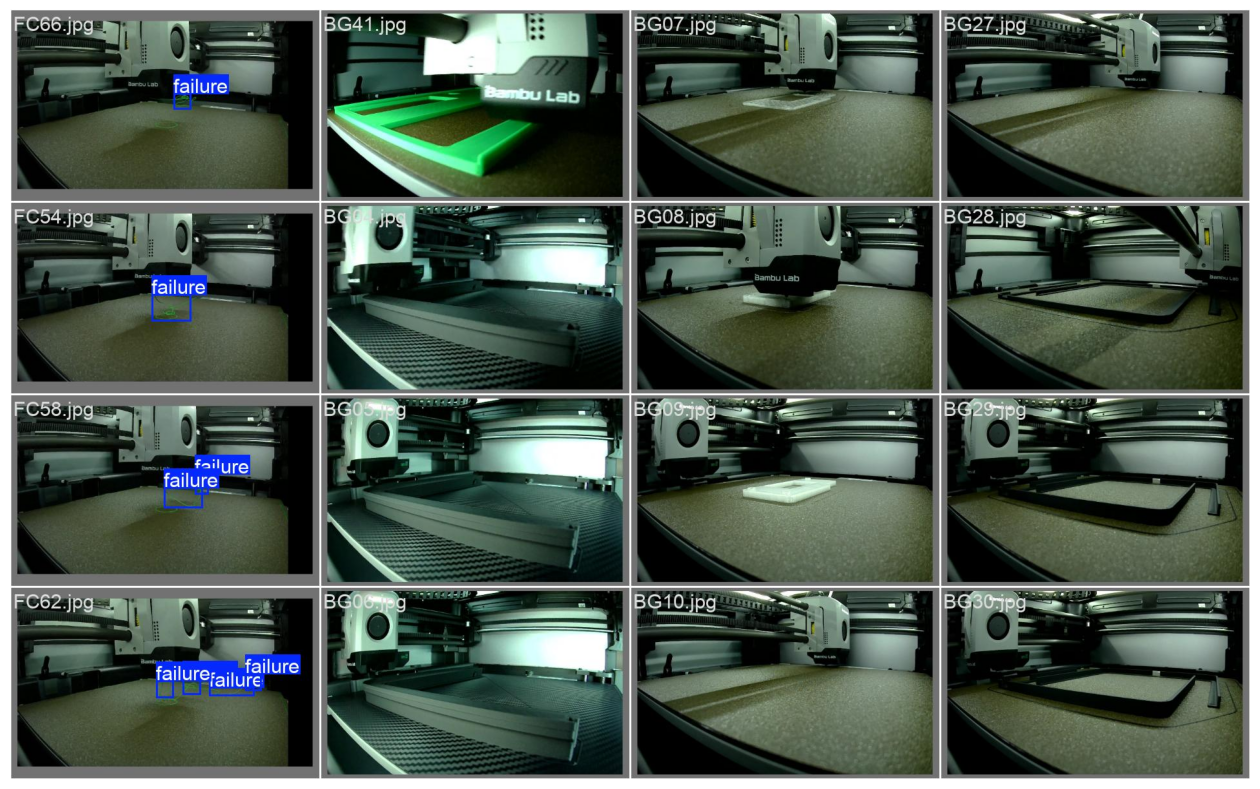



------------------ [LABEL] ./runs/detect/train823/val_batch1_pred.jpg ------------------


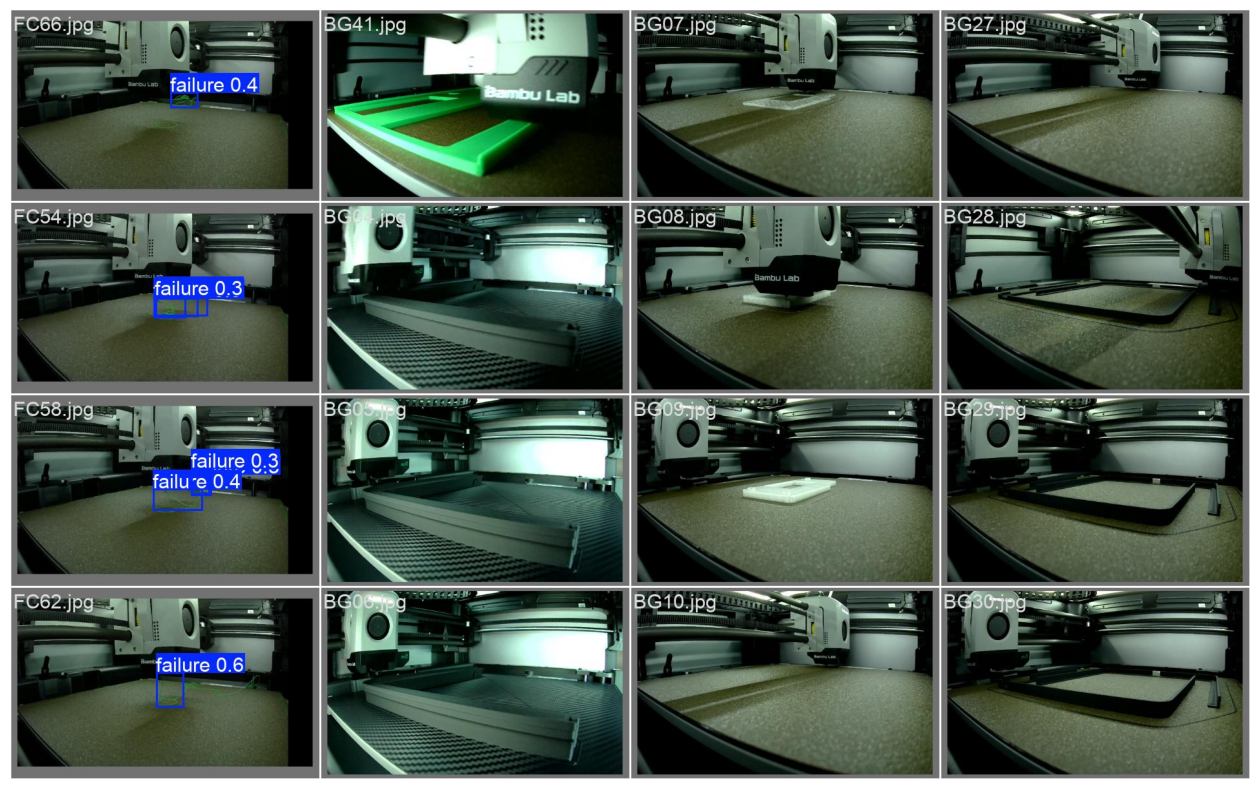

In [52]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Load the image
count = 1
for path in [image1, image2, image3, image4]:

    if ((count % 2) == 0):
        print(f"------------------ [LABEL] {path} ------------------")
    else:
        print(f"------------------ [PREDICTION] {path} ------------------")
    count += 1;

    img = mpimg.imread(path)
    plt.figure(figsize=(16, 16))

    # Display the image
    plt.imshow(img)
    plt.axis('off')  # Hide axes
    plt.show()
    
    print("\n")

# Evaluation

#### *On initial dataset of 350 images!*

- Overall it performed unexpectedly well based on the generated images. Except for FC46.jpg where it was unable to detect the very small loose filament oozing from the nozzle.

- It was able to correctly identify at least one failure from each of the images with failures. 

- Crucially, none of the background images have any false positives. This is important, as it means it has a low false positive rate, or high precision. In most AI fault detection systems, a false positive will cause the print to stop until a human gives it the clearance to proceed if it was a false positive, wasting time.**